# Regime Detection via Hidden Markov Models

## Abstract

We apply Gaussian Hidden Markov Models (HMMs) to identify distinct return regimes in a market-capitalization weighted cryptocurrency portfolio. The portfolio consists of the top 10 cryptocurrencies by market cap, rebalanced weekly, with daily returns analyzed from 2018 to 2025.

## Methodology

### Portfolio Construction

We construct a dynamic market-cap weighted portfolio:
- **Universe**: All cryptocurrencies with available market cap and price data
- **Selection**: Top 10 assets by market capitalization on each rebalancing date
- **Rebalancing Frequency**: Weekly (every Monday)
- **Weighting**: Market-cap weighted within selected assets

### Regime Detection Model

We fit Gaussian HMMs with $K \in \{2,3,4,5\}$ hidden states to the portfolio's daily returns. The model assumes:

$$r_t | s_t = k \sim \mathcal{N}(\mu_k, \sigma_k^2)$$

where $r_t$ is the portfolio return at time $t$, $s_t$ is the hidden regime state, and $(\mu_k, \sigma_k^2)$ are the mean and variance parameters for regime $k$. Regime transitions follow a first-order Markov process with transition matrix $\mathbf{A}$.

Model selection is performed using the Bayesian Information Criterion (BIC):

$$\text{BIC} = -2 \log L + p \log n$$

where $L$ is the likelihood, $p$ is the number of parameters, and $n$ is the sample size.

### Data

- **Period**: 2018-01-01 to 2025-11-24
- **Frequency**: Daily returns
- **Source**: Historical market cap and price data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

from pathlib import Path

from utils import (
    load_aligned_data,
    construct_market_portfolio
)

pd.options.display.float_format = "{:.6f}".format


In [5]:
DATA_DIR = Path("data")
MARKET_CAP_FILE = DATA_DIR / "market_cap.csv"
PRICE_FILE = DATA_DIR / "daily_price.csv"

aligned_market_caps, aligned_prices, asset_returns = load_aligned_data(
    MARKET_CAP_FILE,
    PRICE_FILE,
)

print(f"Aligned market caps shape: {aligned_market_caps.shape}")
print(f"Aligned prices shape: {aligned_prices.shape}")
print(f"Aligned returns shape: {asset_returns.dropna().shape}")


Aligned market caps shape: (2880, 20)
Aligned prices shape: (2880, 20)
Aligned returns shape: (61, 20)


/Users/franklinliu/Projects/MBC_Crypto/MBC-Research/utils.py:44: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change()


In [6]:
# Portfolio configuration: Weekly rebalancing, daily returns
REBALANCING_FREQ = 'W'
TOP_ASSETS = 10

daily_market_portfolio = construct_market_portfolio(
    aligned_market_caps,
    asset_returns,
    rebalancing_freq=REBALANCING_FREQ,
    top_n=TOP_ASSETS,
).dropna()

print(f"Portfolio: {len(daily_market_portfolio)} daily returns")
print(f"Date range: {daily_market_portfolio.index.min()} to {daily_market_portfolio.index.max()}")


Portfolio: 2874 daily returns
Date range: 2018-01-07 00:00:00 to 2025-11-19 00:00:00


## Portfolio Construction

The market-cap weighted portfolio is constructed by selecting the top 10 assets by market capitalization on each weekly rebalancing date.


In [7]:
# Fit HMM on daily returns
def fit_hmm_regimes(return_series: pd.Series, n_states: int = 2, random_state: int = 42):
    """Fit a Gaussian HMM and label regimes by ascending mean return."""
    clean_returns = return_series.dropna()
    data = clean_returns.values.reshape(-1, 1)
    
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type='full',
        n_iter=500,
        random_state=random_state,
    )
    model.fit(data)
    
    raw_states = model.predict(data)
    ordered_states = np.argsort(model.means_.flatten())
    state_mapping = {state: rank for rank, state in enumerate(ordered_states)}
    normalized_states = np.vectorize(state_mapping.get)(raw_states)
    
    if n_states == 2:
        regime_labels = {0: 'Bearish', 1: 'Bullish'}
    else:
        regime_labels = {state: f"Regime {state + 1}" for state in range(n_states)}
    
    regime_df = pd.DataFrame({
        'Return': clean_returns,
        'State': normalized_states,
        'Regime': [regime_labels[s] for s in normalized_states],
    })
    
    log_likelihood = model.score(data)
    n_features = data.shape[1]
    n_params = (
        n_states * (n_states - 1) +
        (n_states - 1) +
        n_states * n_features +
        n_states * n_features * n_features
    )
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(len(clean_returns))
    
    regime_stats = regime_df.groupby('Regime')['Return'].agg(['count', 'mean', 'std', 'min', 'max'])
    
    return {
        'model': model,
        'regime_df': regime_df,
        'regime_stats': regime_stats,
        'log_likelihood': log_likelihood,
        'aic': aic,
        'bic': bic,
    }

# Find best number of states
STATE_RANGE = range(2, 6)
state_results = []
for n_states in STATE_RANGE:
    summary = fit_hmm_regimes(daily_market_portfolio, n_states=n_states, random_state=7)
    summary['states'] = n_states
    state_results.append(summary)
    print(f"States={n_states}: LogL={summary['log_likelihood']:.2f}, AIC={summary['aic']:.2f}, BIC={summary['bic']:.2f}")

best_summary = min(state_results, key=lambda s: s['bic'])
regime_df = best_summary['regime_df'].sort_index()
print(f"\nSelected: {best_summary['states']} states (BIC={best_summary['bic']:.2f})")

# Define colors
unique_regimes = regime_df['Regime'].unique()
color_cycle = plt.get_cmap('tab10')
regime_colors = {reg: color_cycle(i % 10) for i, reg in enumerate(unique_regimes)}

/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_k

States=2: LogL=5305.47, AIC=-10596.94, BIC=-10555.20
States=3: LogL=5370.35, AIC=-10712.70, BIC=-10629.21


/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


States=4: LogL=5377.79, AIC=-10709.59, BIC=-10572.43


/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/FinM/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


States=5: LogL=5401.86, AIC=-10735.73, BIC=-10532.97

Selected: 3 states (BIC=-10629.21)


## HMM Model Fitting

We fit Gaussian HMMs with 2-5 states and select the optimal model using BIC. The HMM identifies distinct return regimes (e.g., bull, bear, neutral) with different mean returns and volatilities.


## Results: Full Period Analysis

### Regime Characteristics

The selected HMM identifies distinct regimes with different return distributions. 

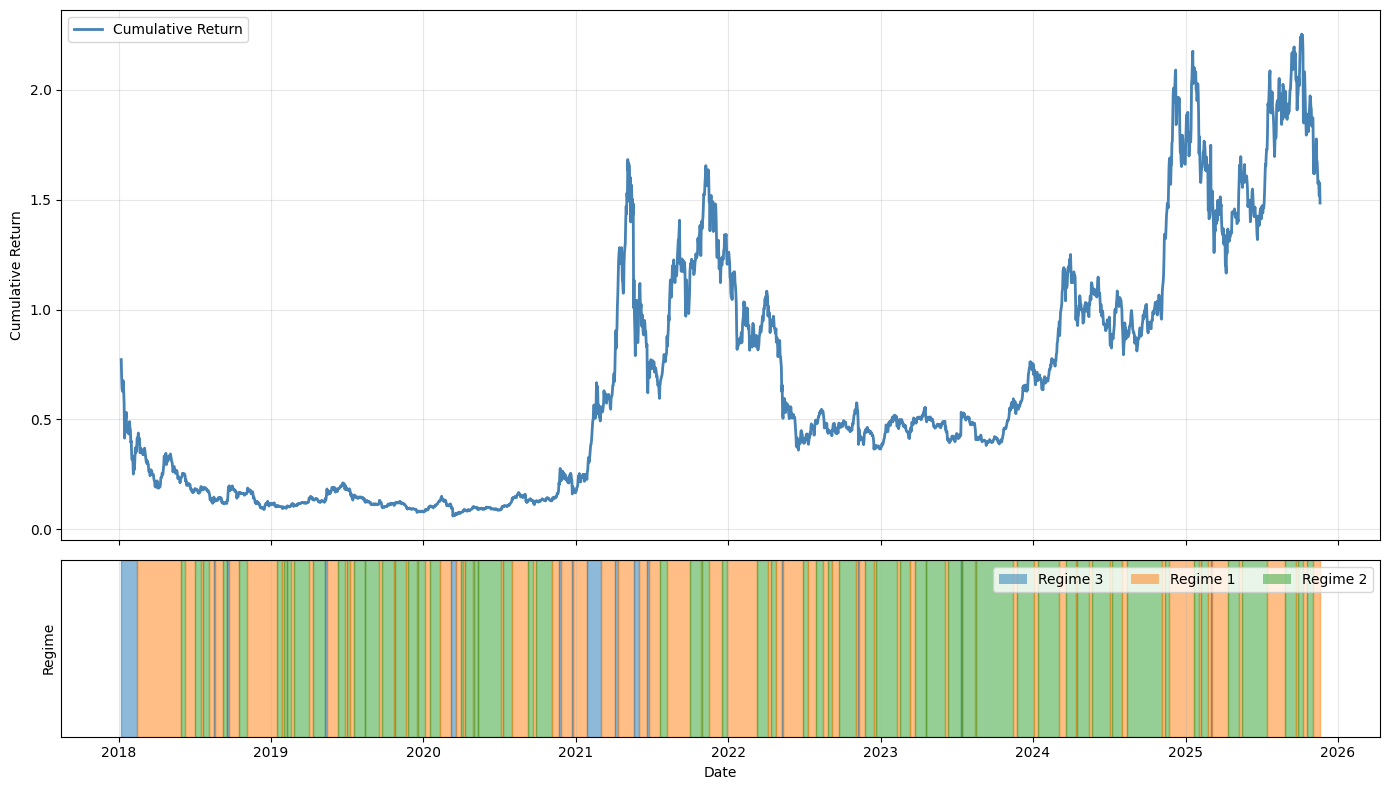

In [9]:
# 1.1 Cumulative returns with regime colors below
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, height_ratios=[3, 1])

# Top: Cumulative returns
cumulative = (1 + regime_df['Return']).cumprod()
ax1.plot(cumulative.index, cumulative.values, color='steelblue', linewidth=2, label='Cumulative Return')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Regime colors
dates = regime_df.index
regimes = regime_df['Regime'].values
prev_regime = None
start_idx = 0
for i, reg in enumerate(regimes):
    if reg != prev_regime:
        if prev_regime is not None:
            ax2.axvspan(dates[start_idx], dates[i], alpha=0.5, color=regime_colors[prev_regime])
        start_idx = i
        prev_regime = reg
if start_idx < len(dates):
    ax2.axvspan(dates[start_idx], dates[-1], alpha=0.5, color=regime_colors[prev_regime])

handles = [plt.Rectangle((0,0),1,1, facecolor=regime_colors[reg], alpha=0.5) for reg in unique_regimes]
ax2.legend(handles, unique_regimes, loc='upper right', ncol=min(len(unique_regimes), 4))
ax2.set_ylabel('Regime')
ax2.set_xlabel('Date')
ax2.set_yticks([])
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [10]:
best_summary

{'model': GaussianHMM(covariance_type='full', n_components=3, n_iter=500, random_state=7),
 'regime_df':               Return  State    Regime
 2018-01-07 -0.228053      2  Regime 3
 2018-01-08 -0.103466      2  Regime 3
 2018-01-09 -0.076177      2  Regime 3
 2018-01-10 -0.017875      2  Regime 3
 2018-01-11  0.068207      2  Regime 3
 ...              ...    ...       ...
 2025-11-15  0.007468      0  Regime 1
 2025-11-16 -0.011175      0  Regime 1
 2025-11-17 -0.031067      0  Regime 1
 2025-11-18  0.037974      0  Regime 1
 2025-11-19 -0.058160      0  Regime 1
 
 [2874 rows x 3 columns],
 'regime_stats':           count      mean      std       min      max
 Regime                                               
 Regime 1   1232 -0.001252 0.048757 -0.154745 0.151782
 Regime 2   1507  0.002328 0.020965 -0.070525 0.071907
 Regime 3    135  0.009577 0.122627 -0.374698 0.249507,
 'log_likelihood': 5370.350096181725,
 'aic': -10712.70019236345,
 'bic': np.float64(-10629.211751430505),
 

## Results: 2025 Analysis

Analysis of regime behavior in 2025, including cumulative returns and regime transitions.


REGIME STATISTICS - FULL DATASET
         Mean (Annualized) Volatility (Annualized) Total Return  Count
Regime                                                                
Regime 1           -45.71%                  93.15%      -95.12%   1232
Regime 2            84.96%                  40.05%     2290.82%   1507
Regime 3           349.55%                 234.28%       27.18%    135


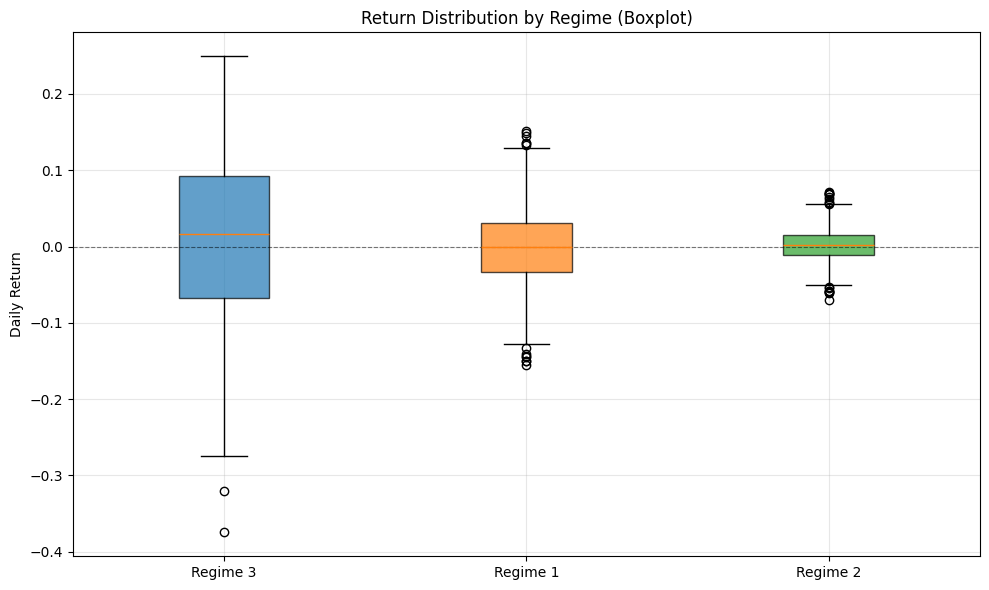

In [11]:
# 1.2 Regime Statistics Table (Mean, Volatility, Total Return)
regime_stats = best_summary['regime_stats']
regime_total_returns = regime_df.groupby('Regime')['Return'].apply(lambda r: (1 + r).prod() - 1)

# Annualize mean and volatility
annual_factor = 365
annualized_mean = regime_stats['mean'] * annual_factor
annualized_vol = regime_stats['std'] * np.sqrt(annual_factor)

# Create comprehensive statistics table
stats_table = pd.DataFrame({
    'Mean (Annualized)': annualized_mean,
    'Volatility (Annualized)': annualized_vol,
    'Total Return': regime_total_returns,
    'Count': regime_stats['count'],
})

# Format as percentages with 2 decimal places
stats_table_formatted = stats_table.copy()
stats_table_formatted['Mean (Annualized)'] = stats_table_formatted['Mean (Annualized)'].apply(lambda x: f"{x:.2%}")
stats_table_formatted['Volatility (Annualized)'] = stats_table_formatted['Volatility (Annualized)'].apply(lambda x: f"{x:.2%}")
stats_table_formatted['Total Return'] = stats_table_formatted['Total Return'].apply(lambda x: f"{x:.2%}")

print("="*70)
print("REGIME STATISTICS - FULL DATASET")
print("="*70)
print(stats_table_formatted)
print("="*70)

# 1.3 Boxplot
fig, ax = plt.subplots(figsize=(10, 6))
box_data = [regime_df.loc[regime_df['Regime'] == reg, 'Return'].values for reg in unique_regimes]
bp = ax.boxplot(box_data, tick_labels=unique_regimes, patch_artist=True)
for patch, reg in zip(bp['boxes'], unique_regimes):
    patch.set_facecolor(regime_colors[reg])
    patch.set_alpha(0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_title('Return Distribution by Regime (Boxplot)')
ax.set_ylabel('Daily Return')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


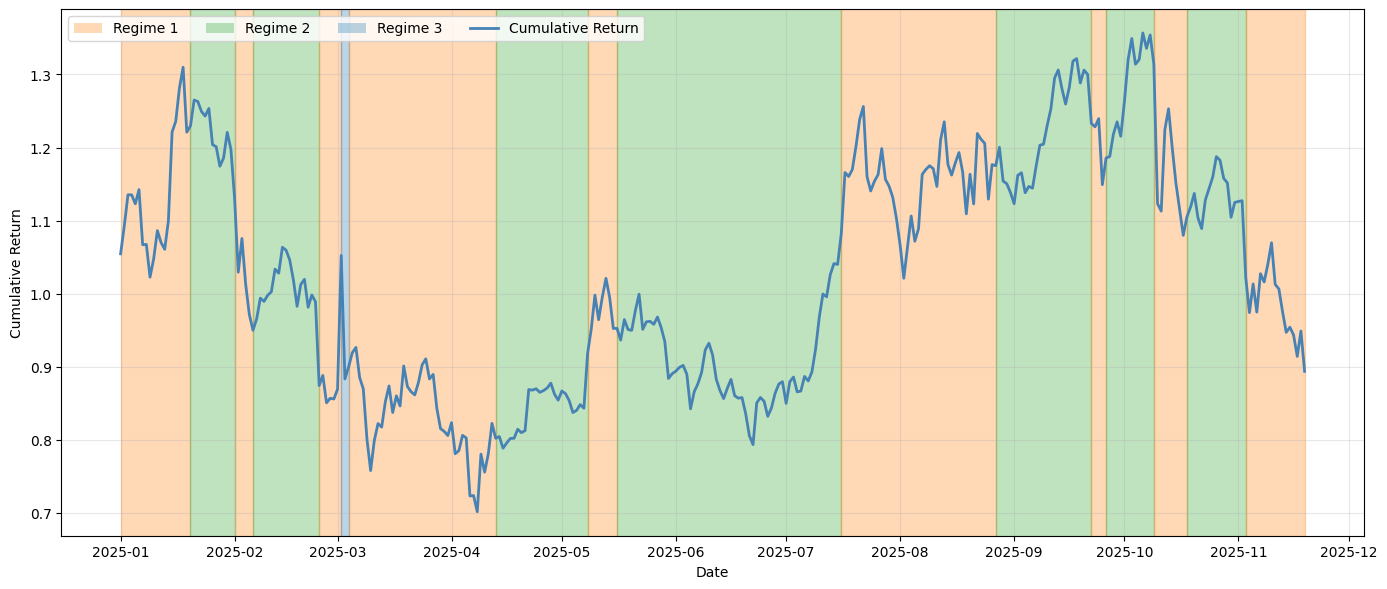

In [13]:
# 2.1 Cumulative returns with regime colors for 2025
regime_df_2025 = regime_df.loc[regime_df.index.year == 2025].copy().sort_index()

if len(regime_df_2025) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Cumulative returns line for 2025
    cumulative_2025 = (1 + regime_df_2025['Return']).cumprod()
    ax.plot(cumulative_2025.index, cumulative_2025.values, color='steelblue', linewidth=2, label='Cumulative Return', zorder=2)
    
    # Regime colors underneath
    dates_2025 = regime_df_2025.index
    regimes_2025 = regime_df_2025['Regime'].values
    prev_regime = None
    start_idx = 0
    for i, reg in enumerate(regimes_2025):
        if reg != prev_regime:
            if prev_regime is not None:
                ax.axvspan(dates_2025[start_idx], dates_2025[i], alpha=0.3, color=regime_colors[prev_regime], zorder=0)
            start_idx = i
            prev_regime = reg
    if start_idx < len(dates_2025):
        ax.axvspan(dates_2025[start_idx], dates_2025[-1], alpha=0.3, color=regime_colors[prev_regime], zorder=0)
    
    unique_regimes_2025 = regime_df_2025['Regime'].unique()
    handles = [plt.Rectangle((0,0),1,1, facecolor=regime_colors[reg], alpha=0.3) for reg in unique_regimes_2025]
    ax.legend(handles + [plt.Line2D([0], [0], color='steelblue', linewidth=2)], 
              list(unique_regimes_2025) + ['Cumulative Return'], 
              loc='upper left', ncol=min(len(unique_regimes_2025) + 1, 5))
    ax.set_ylabel('Cumulative Return')
    ax.set_xlabel('Date')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for 2025")


## Regime Duration Analysis

We analyze the duration distribution of bearish (Regime 1) periods:
- **Unconditional distribution**: Distribution of all bearish regime lengths
- **Conditional distribution**: Distribution of remaining length given current duration $k$

This analysis helps understand regime persistence and potential duration forecasting.


SUMMARY OF ALL REGIMES
Regime 1: 72 periods, mean length: 17.11 days
Regime 2: 59 periods, mean length: 25.54 days
Regime 3: 15 periods, mean length: 9.00 days

Regime 1 (Bearish) identified as: Regime 1 (mean return: -0.001252)

UNCONDITIONAL DISTRIBUTION OF REGIME 1 (BEARISH) LENGTHS

Unconditional Distribution:
Length          Count           Probability    
---------------------------------------------
1               5               0.0694         
2               2               0.0278         
3               5               0.0694         
4               6               0.0833         
5               4               0.0556         
6               4               0.0556         
7               3               0.0417         
8               5               0.0694         
9               2               0.0278         
10              3               0.0417         
11              3               0.0417         
12              1               0.0139         
13            

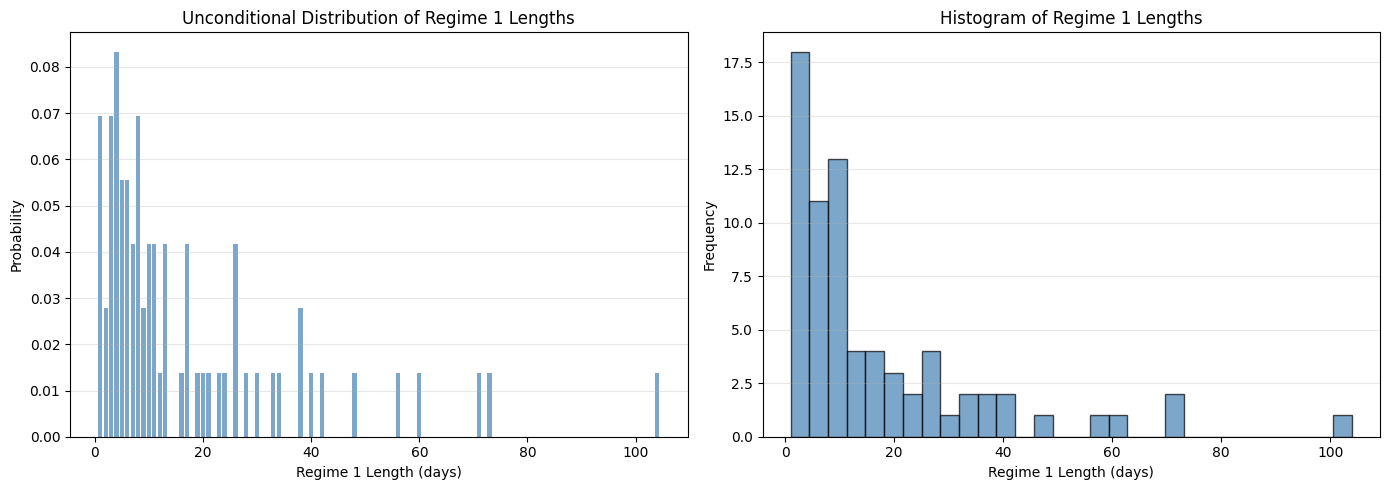


MEAN LENGTH OF BEARISH (REGIME 1)
Mean Regime 1 Length: 17.11 days
Median: 9.50 days
Std Dev: 19.41 days
Min: 1 days, Max: 104 days
Total number of Regime 1 periods: 72


In [14]:
# 2.2.1 Unconditional Distribution of Regime 1 (Bearish) Lengths
def calculate_regime_lengths(regime_series):
    """Calculate lengths of consecutive regime periods."""
    lengths = []
    current_regime = None
    current_length = 0
    
    for reg in regime_series:
        if reg == current_regime:
            current_length += 1
        else:
            if current_regime is not None:
                lengths.append((current_regime, current_length))
            current_regime = reg
            current_length = 1
    if current_regime is not None:
        lengths.append((current_regime, current_length))
    
    return lengths

# Show summary of all regimes
print("="*70)
print("SUMMARY OF ALL REGIMES")
print("="*70)
all_lengths = calculate_regime_lengths(regime_df['Regime'].values)
regime_summary = {}
for regime, length in all_lengths:
    if regime not in regime_summary:
        regime_summary[regime] = []
    regime_summary[regime].append(length)

for regime in sorted(regime_summary.keys()):
    lengths = regime_summary[regime]
    print(f"{regime}: {len(lengths)} periods, mean length: {np.mean(lengths):.2f} days")
print()

# Identify regime 1 (lowest mean return - bearish)
regime_means = regime_df.groupby('Regime')['Return'].mean()
regime1 = regime_means.idxmin()
print(f"Regime 1 (Bearish) identified as: {regime1} (mean return: {regime_means[regime1]:.6f})\n")

# Calculate all regime lengths
regime1_lengths = np.array([length for regime, length in all_lengths if regime == regime1])

if len(regime1_lengths) > 0:
    # Unconditional distribution of regime 1 lengths
    unique_lengths, counts = np.unique(regime1_lengths, return_counts=True)
    unconditional_dist = pd.Series(counts, index=unique_lengths) / len(regime1_lengths)
    
    print("="*70)
    print("UNCONDITIONAL DISTRIBUTION OF REGIME 1 (BEARISH) LENGTHS")
    print("="*70)
    print("\nUnconditional Distribution:")
    print(f"{'Length':<15} {'Count':<15} {'Probability':<15}")
    print("-"*45)
    for length, prob in sorted(unconditional_dist.items()):
        count = counts[unique_lengths == length][0]
        print(f"{length:<15} {count:<15} {prob:<15.4f}")
    
    # Visualize unconditional distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.bar(unconditional_dist.index, unconditional_dist.values, alpha=0.7, color='steelblue')
    ax1.set_xlabel('Regime 1 Length (days)')
    ax1.set_ylabel('Probability')
    ax1.set_title('Unconditional Distribution of Regime 1 Lengths')
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2.hist(regime1_lengths, bins=min(30, len(unique_lengths)), alpha=0.7, color='steelblue', edgecolor='black')
    ax2.set_xlabel('Regime 1 Length (days)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Histogram of Regime 1 Lengths')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Mean of unconditional distribution
    print("\n" + "="*70)
    print("MEAN LENGTH OF BEARISH (REGIME 1)")
    print("="*70)
    mean_length = np.mean(regime1_lengths)
    print(f"Mean Regime 1 Length: {mean_length:.2f} days")
    print(f"Median: {np.median(regime1_lengths):.2f} days")
    print(f"Std Dev: {np.std(regime1_lengths):.2f} days")
    print(f"Min: {np.min(regime1_lengths)} days, Max: {np.max(regime1_lengths)} days")
    print(f"Total number of Regime 1 periods: {len(regime1_lengths)}")
else:
    print("No Regime 1 periods found in the data")

In [15]:
# 2.2.2 Conditional Distribution of Regime 1 (Bearish) Length
k = 18  # Define the current length to analyze

if len(regime1_lengths) > 0:
    print("="*70)
    print(f"CONDITIONAL DISTRIBUTION OF REGIME 1 (BEARISH) LENGTH")
    print(f"Given current_length >= {k}")
    print("="*70)
    print(f"P(Length = k | Length >= {k})")
    print("-"*70)
    
    max_length = int(np.max(regime1_lengths))
    print(f"Maximum Regime 1 length observed: {max_length} days\n")
    
    # Filter to periods that are at least k days long
    periods_at_least = regime1_lengths[regime1_lengths >= k]
    
    if len(periods_at_least) > 0:
        # Conditional distribution: P(length = k | length >= k)
        conditional_probs = {}
        for length_k in range(k, max_length + 1):
            count_k = np.sum(periods_at_least == length_k)
            if count_k > 0:
                conditional_probs[length_k] = count_k / len(periods_at_least)
        
        if len(conditional_probs) > 0:
            print(f"\nConditional Distribution given current_length >= {k}:")
            print(f"{'Length (k)':<15} {'P(k | >= {})'.format(k):<15}")
            print("-"*30)
            for length_k in sorted(conditional_probs.keys()):
                print(f"{length_k:<15} {conditional_probs[length_k]:<15.4f}")
            
            expected_length = sum(length_k * p for length_k, p in conditional_probs.items())
            print(f"\nExpected total length: {expected_length:.2f} days")
            print(f"Number of periods with length >= {k}: {len(periods_at_least)}")
        else:
            print(f"No periods found with length >= {k}")
    else:
        print(f"No periods found with length >= {k}")
else:
    print("No Regime 1 periods found - cannot calculate conditional distribution")


CONDITIONAL DISTRIBUTION OF REGIME 1 (BEARISH) LENGTH
Given current_length >= 18
P(Length = k | Length >= 18)
----------------------------------------------------------------------
Maximum Regime 1 length observed: 104 days


Conditional Distribution given current_length >= 18:
Length (k)      P(k | >= 18)   
------------------------------
19              0.0455         
20              0.0455         
21              0.0455         
23              0.0455         
24              0.0455         
26              0.1364         
28              0.0455         
30              0.0455         
33              0.0455         
34              0.0455         
38              0.0909         
40              0.0455         
42              0.0455         
48              0.0455         
56              0.0455         
60              0.0455         
71              0.0455         
73              0.0455         
104             0.0455         

Expected total length: 40.00 days
Number of perio